In [3]:
import os
import random
import pandas as pd
from IPython.display import Audio
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import normalize
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchaudio
import torchaudio.transforms as a_T
import torchvision.transforms as v_T
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.restoration import denoise_wavelet

In [133]:
dataset_path = "/home/rishabh/UofT/fourthYear/capstone/birdclef-2022/train_audio"
class Species:
    def __init__(self, name, recordings):
        self.name = name
        self.recordings = recordings
        self.len = len(self.recordings)
        
    def set_label(self, label):
        #Label of a specie based on the number of recrdings the dataset has
        self.label = label
    
    def __repr__(self):
        return '{' + 'Name:' + self.name + ', ' + 'No. Recs:' + str(self.len) + ', ' + 'Label:' + str(self.label) + '}'

def get_spectrogram(wave: torch.Tensor, sample_rate=16000, n_fft=1024, hop_length=512, n_mels=40):
  mel_spectrogram = a_T.MelSpectrogram(sample_rate, n_fft, hop_length, n_mels)
  melspec = mel_spectrogram(wave)
  return melspec

def plot_wave_and_spectrogram(wave: torch.Tensor, melspec: torch.Tensor, label="BirdCall"):
  fig, (ax1, ax2) = plt.subplots(2,1)
  fig.suptitle(label)
  ax1.plot(wave)
  ax2.imshow(librosa.power_to_db(melspec), origin="lower", aspect="auto", interpolation="nearest")

def preprocess_one_audio(path, target_duration=2, target_sr=16000):
    #Load, mono, downsample, take random 30 sec crop
    y, sr = torchaudio.load(r)
    mono = y
    if(len(y) == 2):
        mono = torch.unsqueeze(y[0], 0)
    downsample = a_T.Resample(sr, target_sr)(mono)
    duration = 30
    crop = v_T.RandomCrop((1, duration*target_sr), pad_if_needed=True)(downsample)
    
    #PCEN-SNR Technique to get most imp 1 sec clip
    def get_peaks(y, sr, n_peaks=12, kernel_size=15, zero_dist=50, FMIN=500, FMAX=12500):
        # Spec
        melspec = librosa.feature.melspectrogram(y=y, sr=sr,
            fmin=FMIN, fmax=FMAX, n_mels=64)
        pcen = librosa.core.pcen(melspec, sr=sr,
            gain=0.8, bias=10, power=0.25, time_constant=0.06, eps=1e-06)
        # SNR
        pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
        avg_pcen_snr = np.median(pcen_snr)
        if avg_pcen_snr == 0:
            if np.mean(pcen_snr) == 0:
                avg_pcen_snr = 1
            else:
                avg_pcen_snr = np.mean(pcen_snr)
        pcen_snr = librosa.power_to_db(pcen_snr / avg_pcen_snr)
        # SMoothed SNR
        median_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
        # And go through, picking some peaks
        times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
        peak_locs = []
        for i in range(n_peaks):
            t_peak = np.argmax(median_pcen_snr)
            peak_locs.append(times[t_peak])
            median_pcen_snr[t_peak-50:t_peak+50] = 0 # zero out around the peak to find the next one
        return peak_locs

    peaks = get_peaks(crop[0].numpy(), target_sr, n_peaks=20)
    start_time = min(len(crop[0])/target_sr - target_duration, max(float(peaks[0])-target_duration/2, target_duration/2))
    start_frame = int(start_time * target_sr)
    stop_frame = start_frame + target_duration * target_sr
    chopped = crop[0][start_frame: stop_frame]
    x_denoise = torch.tensor(denoise_wavelet(chopped.numpy(), method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True'))
    normalize_amp = normalize(x_denoise, dim=0)
    return normalize_amp, target_sr

In [134]:
species = []
for path in os.listdir(dataset_path):
    recordings = []
    for rec in os.listdir(f"{dataset_path}/{path}"):
        recordings.append(f"{dataset_path}/{path}/{rec}")
    species.append(Species(path, recordings))
species.sort(key=lambda s: s.len, reverse=True)
for i, specie in enumerate(species):
    specie.set_label(i)    

In [135]:
print(species[:4])

[{Name:mallar3, No. Recs:500, Label:0}, {Name:brnowl, No. Recs:500, Label:1}, {Name:houspa, No. Recs:500, Label:2}, {Name:comsan, No. Recs:500, Label:3}]


In [38]:
r = random.choice(species[1].recordings)
print(r)
Audio(r)

/home/rishabh/UofT/fourthYear/capstone/birdclef-2022/train_audio/brnowl/XC597985.ogg


In [68]:
y, sr = preprocess_one_audio(r)
Audio(y, rate=sr)

torch.Size([128, 801])


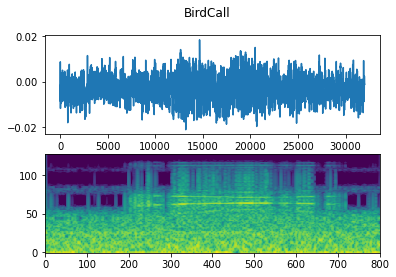

In [74]:
melspec = get_spectrogram(y)
print(melspec.shape)
plot_wave_and_spectrogram(y, melspec)

In [194]:
def get_labelled_data(species, num_of_species=2, num_of_recs_per_species=10, split_train=0.8, split_val=0.1, split_test=0.1):
    #Ensures equal amount of data per species in train, val, test set
    def get_XY(start, end):
        #Array of tuples(X: melspec, Y: label of the bird, Z: Path of the rec for verification)
        X, Y, Z = [], [], []
        for specie in species[:num_of_species]:
            recs = specie.recordings[start:end]
            for rec in recs:
                y, sr = preprocess_one_audio(rec)
                melspec = get_spectrogram(y)
                X.append(melspec)
                Y.append(specie.label)
                Z.append(rec)
        return [torch.stack(X), torch.tensor(Y), Z]
    data_train = get_XY(0, int(num_of_recs_per_species*split_train))
    data_val = get_XY(int(num_of_recs_per_species*split_train), int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val))
    data_test = get_XY(int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val), int(num_of_recs_per_species*split_train + num_of_recs_per_species*split_val + num_of_recs_per_species*split_test))
    return data_train, data_val, data_test

def save_labelled_data(train, val, test):
    X_train, Y_train = train[0], train[1]
    X_val, Y_val = val[0], val[1]
    X_test, Y_test = test[0], test[1]
    torch.save(X_train.clone().detach(), 'classifier_X_train.pt')
    torch.save(Y_train.clone().detach(), 'classifier_Y_train.pt')
    torch.save(X_val.clone().detach(), 'classifier_X_val.pt')
    torch.save(Y_val.clone().detach(), 'classifier_Y_val.pt')
    torch.save(X_test.clone().detach(), 'classifier_X_test.pt')
    torch.save(Y_test.clone().detach(), 'classifier_Y_test.pt')
    X_train, Y_train, X_test, Y_test = None, None, None, None
    del X_train
    del Y_train
    del X_test
    del Y_test

def retrieve_labelled_data():
    X_train, Y_train = torch.load('classifier_X_train.pt'), torch.load('classifier_Y_train.pt') 
    X_val, Y_val = torch.load('classifier_X_val.pt'), torch.load('classifier_Y_val.pt')
    X_test, Y_test = torch.load('classifier_X_test.pt'), torch.load('classifier_Y_test.pt')
    return [X_train, Y_train], [X_val, Y_val], [X_test, Y_test]
    
def get_data_samplers(train, val, random_seed=20):
    #shuffle training, val data
    def shuffle_indices(indices):
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler
    train_sampler = shuffle_indices(list(range(len(train))))
    val_sampler = shuffle_indices(list(range(len(val))))
    return train_sampler, val_sampler

In [205]:
train, val, test = get_labelled_data(species)
save_labelled_data(train, val, test)
train1, val1, test1 = retrieve_labelled_data()
train_sampler, val_sampler = get_data_samplers(train1, val1)

In [223]:
class ClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super(ClassifierDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.len = X.size(0)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
classifier_train_dataset = ClassifierDataset(train1[0], train1[1])
classifier_val_dataset = ClassifierDataset(val1[0], val1[1])
classifier_test_dataset = ClassifierDataset(test1[0], test1[1])

In [224]:
batch_size = 2
train_loader = torch.utils.data.DataLoader(classifier_train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(classifier_val_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(classifier_test_dataset, batch_size=batch_size)

In [2]:
#Defining the Classifier module
class Classifier(nn.Module):
    
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.n_classes = n_classes
        self.lin_size = 64*8*50
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.lin_size, 128)
        self.fc2 = nn.Linear(128, n_classes)
    
    def forward(self, x):
        #conv block
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.pool(x)
        x = self.drop(x)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.pool(x)
        x = self.drop(x)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.pool(x)
        x = self.drop(x)
        #lin blocks
        x = x.view(-1, self.lin_size)
        x = F.leaky_relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

In [11]:
model = Classifier(n_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.NLLLoss()

In [13]:
# train the network with low epochs